![Banner](img/AI_Special_Program_Banner.jpg)

## Hyperparameter Optimization (HPO) w/ Optuna - Workshop - Solution Part 1
---

***Data Source**: [Kaggle](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification)*

***Optuna Documentation**: [https://optuna.readthedocs.io/en/stable/](https://optuna.readthedocs.io/en/stable/)*

# Hyperparameter Optimization (HPO) w/ Optuna - Study & Objective Function
---

To get a Optuna pipeline running, usually the first steps should be:
* To define a **study object** which describes the intent and used methodology for the optimization process
* To create an **objective function** that receives updates on the model's 'fitness' during training
* To declare valid ranges and values for selected parameters
* To run the study for a given number of **trials** in which optimization is performed

> **Library imports and general settings**:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR

import torch
import torch.nn as nn

###
import optuna
import torch.optim as optim
###

In [2]:
EPOCHS = 50
CLASSES = 3

torch.manual_seed(42)
random.seed(42)
RANDOM_SEED = 42

> **Definition of (selected) hyperparameters**:

> **Data preparation**:

In [3]:
data = pd.read_csv('data/HPO_Data.csv')
data.head()

,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [4]:
len(data)

2126

In [5]:
data.isnull().any().any()

False

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

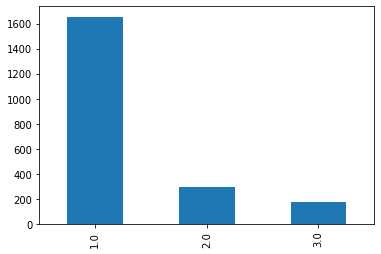

In [6]:
data.fetal_health.value_counts().plot(kind='bar')
data.fetal_health.value_counts()

In [7]:
null_accuracy = data.fetal_health.value_counts()[1.0]/len(data)
null_accuracy

0.7784571966133584

In [8]:
encoder = OrdinalEncoder()
oe_columns = ['fetal_health']
encoder.fit(data[oe_columns])
data[oe_columns] = encoder.transform(data[oe_columns])

In [9]:
data.fetal_health.value_counts()

0.0    1655
1.0     295
2.0     176
Name: fetal_health, dtype: int64

> **Creating helper classes and methods**:

In [10]:
class FetalHealthData(torch.utils.data.Dataset):
    def __init__(self, data):
        self.labels = data.fetal_health.tolist()
        self.features = data.drop(columns=['fetal_health'], axis=1).values.tolist()
    
    def __getitem__(self, index):
        sample = np.array(self.features[index]), np.array(self.labels[index])
        return sample
        
    def __len__(self):
        return len(self.labels)

In [11]:
# HP: Hiden Layer 0, Hidden Layer 1
def get_model(params):
    
    ###
    layer_0 = params['layer_0']
    layer_1 = params['layer_1']
    ###
    
    layers = list()
    
    # 21 Input Features
    in_features = len(data.drop(columns=['fetal_health'], axis=1).columns)
    
    # Input Layer -> Hidden Layer 0
    layers.append(nn.Linear(in_features, layer_0))
    layers.append(nn.LeakyReLU())
    
    # Hidden Layer 0 -> Hidden Layer 1
    layers.append(nn.Linear(layer_0, layer_1))
    layers.append(nn.LeakyReLU())
    
    # Hidden Layer 1 -> Output Layer (3 Classes)
    layers.append(nn.Dropout())
    layers.append(nn.Linear(layer_1, CLASSES))

    return nn.Sequential(*layers)

In [12]:
# HP: Batch Size
def get_data(params):
    
    ###
    batch_size = params['batch_size']
    ###
    
    training_data, testing_data = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, stratify=data.fetal_health)
    training_data, testing_data = FetalHealthData(training_data), FetalHealthData(testing_data)
    return torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True), torch.utils.data.DataLoader(testing_data, batch_size=batch_size, shuffle=False)

In [13]:
# HP: Optimizer, Learning Rate, Weight Decay
def get_optimizer(model, params):
    
    ###
    optimizer = params['optimizer']
    learning_rate = params['learning_rate']
    weight_decay = params['weight_decay']
    ###
    
    if optimizer == 'Adam':
        return torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer == 'SGD':
        return torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer == 'RMSprop':
        return torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # return getattr(optim, optimizer)(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

> **Creating training loop**:

In [14]:
# HP: Scheduler
def train(model, training_batches, testing_batches, params):
    ###
    scheduler = params['scheduler']
    ###
    
    accuracy = list()
    criterion = nn.CrossEntropyLoss()
    
    ###
    optimizer = get_optimizer(model, params)
    ###
    
    if scheduler:
        scheduler = CosineAnnealingLR(optimizer, EPOCHS-1, verbose=False)
    
    for epoch in range(EPOCHS):
        ### Training
        model.train()
        for samples, labels in training_batches:
            optimizer.zero_grad()
            outputs = model(samples.float())
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        num_samples = 0
        correct_predictions = 0
        ### Testing
        model.eval()
        with torch.no_grad():
            for samples, labels in testing_batches:
                output = model(samples.float())
                correct_predictions += (output.argmax(dim=1) == labels).sum().item()
                num_samples += labels.size(0)
            
        accuracy.append(100.0 * correct_predictions / num_samples)
    
    return accuracy

> **Creating a study object (in memory)**:

In [15]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))

[I 2024-01-30 20:02:09,888] A new study created in memory with name: no-name-83b4dbbb-17a1-4627-8290-c188d20a6cc1


> **Defining an objective function**:

In [16]:
def objective(trial):
    params = {
        'layer_0': trial.suggest_int('layer_0', 8, 256),
        'layer_1': trial.suggest_int('layer_1', 8, 256),
        'batch_size': trial.suggest_int('batch_size', 8, 128),
        'optimizer': trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'RMSprop']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'weight_decay': trial.suggest_loguniform('weight_decay', 1e-5, 1e-1),
        'scheduler': True if trial.suggest_int('scheduler', 0, 1) == 1 else False
    }
    
    model = get_model(params)
    training_batches, testing_batches = get_data(params)
    history = train(model, training_batches, testing_batches, params)
    
    # Fitness-Value
    return history[-1]

> **Optimizing parameters**:

In [17]:
study.optimize(objective, n_trials=10)

[I 2024-01-30 20:02:11,696] Trial 0 finished with value: 77.93427230046949 and parameters: {'layer_0': 101, 'layer_1': 244, 'batch_size': 96, 'optimizer': 'SGD', 'learning_rate': 1.7073967431528103e-05, 'weight_decay': 0.029154431891537533, 'scheduler': 1}. Best is trial 0 with value: 77.93427230046949.
[I 2024-01-30 20:02:12,846] Trial 1 finished with value: 77.93427230046949 and parameters: {'layer_0': 184, 'layer_1': 13, 'batch_size': 125, 'optimizer': 'SGD', 'learning_rate': 5.415244119402538e-05, 'weight_decay': 0.00016480446427978953, 'scheduler': 1}. Best is trial 0 with value: 77.93427230046949.
[I 2024-01-30 20:02:14,381] Trial 2 finished with value: 85.91549295774648 and parameters: {'layer_0': 115, 'layer_1': 80, 'batch_size': 82, 'optimizer': 'RMSprop', 'learning_rate': 0.0006672367170464204, 'weight_decay': 0.013826232179369865, 'scheduler': 0}. Best is trial 2 with value: 85.91549295774648.
[I 2024-01-30 20:02:19,001] Trial 3 finished with value: 77.93427230046949 and par

In [18]:
study.best_params

{'layer_0': 156,
 'layer_1': 237,
 'batch_size': 18,
 'optimizer': 'RMSprop',
 'learning_rate': 0.00035868164986275477,
 'weight_decay': 0.00012172958098369953,
 'scheduler': 1}